# Medical Image Classification

I will leverage the power of computer vision to classify metastatic cancer in small images taken from pathology scans
<center> <img src="https://www.rogelcancercenter.org/images/metastatic-breast-cancer-cells.jpg" width="30%" alt="Metastatic Breast Cancer Cells"> </center>
<center>               Image Source: University of Michigan Health </center>

## Installing libraries

In [1]:
#PyTorch
! pip install --upgrade torch

#Data from IBM SkillsNetwork
import skillsnetwork
await skillsnetwork.download_dataset("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0W5QEN/data/labels.csv")
await skillsnetwork.download_dataset("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0W5QEN/data/data_sample.zip")


import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

%matplotlib inline

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset, random_split
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

Saved as 'labels.csv'


Saved as 'data_sample.zip'


## Defining function to plot tensor data

In [2]:
from numpy import clip , array
from matplotlib import pyplot as plt
from torch import Tensor

def imshow(inp: Tensor) -> None:
    inp = inp.cpu().numpy()
    inp = inp.transpose((1, 2, 0))
    mean = array([0.485, 0.456, 0.406])
    std = array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

## Dataset

The PatchCamelyon dataset consists of color images (96 x 96px) from histopathologic scans of lymph node sections. Each image is labeled with a binary indicating metastatic tissue. 

<center> <img src="https://github.com/basveeling/pcam/raw/master/pcam.jpg" width="100%" alt="CNN pretrained"> <br>
    Example images from PCam. Green boxes indicate tumor tissue in center region, which dictates a positive label.
</center>

Let's unzip and load the data

In [3]:
import zipfile
from tqdm import tqdm

with zipfile.ZipFile("data_sample.zip", "r") as zip_ref:
    total_files = len(zip_ref.infolist())
    for file in tqdm(zip_ref.infolist(), total=total_files):
        zip_ref.extract(file, "data_sample")
os.remove("data_sample/data_sample/.DS_Store")

100%|██████████| 8021/8021 [06:48<00:00, 19.61it/s]


In [4]:
labels_df = pd.read_csv("labels.csv")
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Let's visualize some samples from the data set

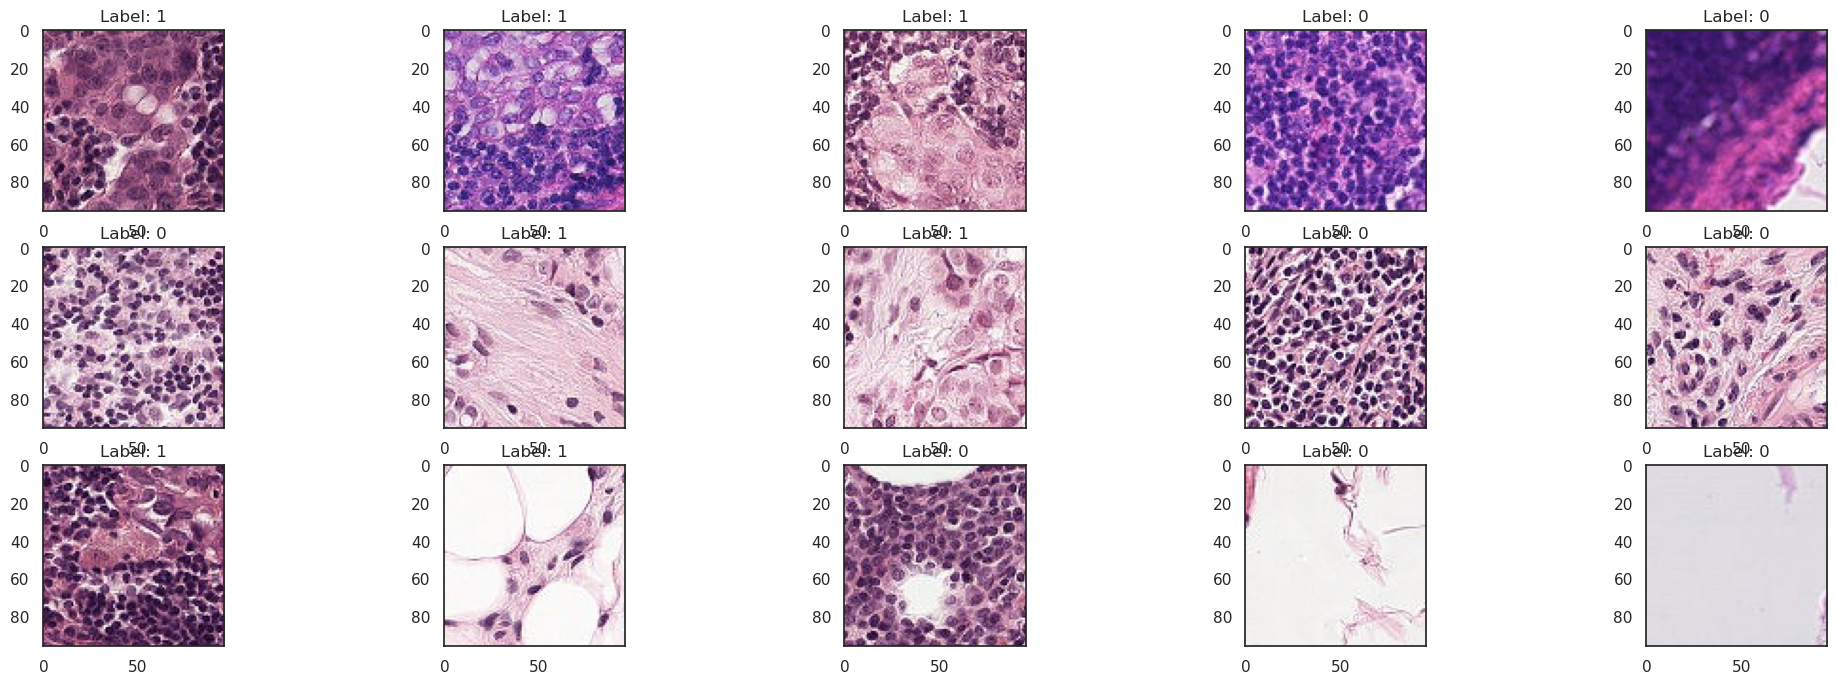

In [5]:
fig = plt.figure(figsize=(25, 8))

path = "data_sample/data_sample"

train_imgs = os.listdir(path)

#I will iterates over a randomly chosen subset of 30 images from the list of all images
for idx, img in enumerate(np.random.choice(train_imgs, 15)):
    
    # add a subplot to the figure
    # specify that there will be 3 rows and 10 columns of subplots
    ax = fig.add_subplot(3, 5, idx+1)
    
    # open the current image file
    im = Image.open(path + "/" + img)
    
    plt.imshow(im)
    lab = labels_df.loc[labels_df["id"] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')


# cancer_dataset class

The cancer_dataset class inherits from the Dataset class in the PyTorch framework, it's designed to load and manage a medical image dataset related to cancer, with associated labels, allowing flexibility for training, validation, and testing subsets through specified dataset types.

In [6]:
class cancer_dataset(Dataset):
    def __init__(self, data_dir, transform, dataset_type=None):
        # Get the path to the directory containing the images
        path2data = os.path.join(data_dir, "data_sample/data_sample")
        
        # Get a list of the filenames of the images in the directory
        filenames = os.listdir(path2data)

        # Get the full path to each image
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        # Load the labels from a CSV file
        path2labels = os.path.join(data_dir, "labels.csv")
        labels_df = pd.read_csv(path2labels)

        # Set the "id" column as the index for the labels dataframe
        labels_df.set_index("id", inplace=True)

        # Obtain the labels for the dataset based on the specified type
        if dataset_type == "train":
            # Only use a subset of the images for training
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][:3608]
            self.full_filenames = [os.path.join(path2data, f) for f in filenames][:2608]
            print("Training dataset")
            
        elif dataset_type == "val":
            # Only use a subset of the images for validation
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][3608:3648]
            self.full_filenames = [os.path.join(path2data, f) for f in filenames][3508:3648]
            print("Validation dataset")
            
        elif dataset_type == "test":
            # Only use a subset of the images for testing
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][3648:-1]
            self.full_filenames = [os.path.join(path2data, f) for f in filenames][3648:-1]
            print("Testing dataset")
            
        else:
            # Use all the images for the dataset
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]

        # Save the data transformation to be applied to each image
        self.transform = transform

    def __len__(self):
        # Return the size of the dataset (i.e., the number of images)
        return len(self.full_filenames)

    def __getitem__(self, idx):
        # Open the image file and apply the data transformation
        img = Image.open(self.full_filenames[idx]) # PIL image
        img = self.transform(img)
        
        # Return the transformed image along with its label
        return img, self.labels[idx]


# Transforming the dataset

To prepare the dataset, I'll define a transformation process called "composed." which involves resizing, horizontally flipping, and rotating the images. Additionally, I'll convert the images to PyTorch tensors and normalize their channels. The goal is to create transformed copies of the images suitable for training in a PyTorch-based model.

In [7]:
from torchvision import transforms

# data transformation 
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
composed_train = transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(degrees=5),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)
                               ])

# for valiadationa and test sets
composed= transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)
                               ])

In [8]:
import os 
from os import listdir
from os.path import isfile, join 

# Define path to directory
mypath = "data_sample/data_sample"

# Get list of only file names in directory
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [9]:
labels_df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [10]:
# Let's load the dataset and look at a sample
data_dir = "./"
dataset_full = cancer_dataset(data_dir , transform=composed)

In [11]:
img, label = dataset_full [19]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 224, 224]) tensor(-2.0357) tensor(2.6400)


# Splitting the dataset

In [12]:
# creating the object of cancer_dataset for train, test, and validation
training_set = cancer_dataset(data_dir, transform=composed_train, dataset_type="train")
test_set = cancer_dataset(data_dir, transform=composed, dataset_type="test")

Training dataset
Testing dataset


# DataLoader, Loading the model

In [13]:
# Load data
train_loader = torch.utils.data.DataLoader(training_set, batch_size=10, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=False, num_workers=2)

# Define classes
num_classes = 2
print("done")

done


In [14]:
#Hyperparameteres : 
# Batch size: train set  
batch_size = 30

# Learning rate  
lr = 3e-4

# Number epochs 
n_epochs = 5

I will use the pre-trained model, ResNet34, a state-of-the-art image classification network by Microsoft.

The original network was designed for classifying the image to 1,000 different classes. I only have 2 classes. For that reason, I'll replace the final layer to reduce the number of neurons from 1,000 to 2.

In [15]:
from torchvision import models

model = models.resnet34(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/jupyterlab/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

# Optimal Model

I'll use cross entropy loss as a metric

In [16]:
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()

In [17]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr = lr)

By freezing the parameters, we ensure that the pre-trained weights are not updated during the training process. Instead, only the parameters of the newly added layers or the layers that are not frozen are updated. This allows the reusability of the knowledge that the pre-trained model has learned while training the new layers on a new task.

In [18]:
num_classes = 2
# Load pretrained model
model = models.resnet34(pretrained=True)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False

# Modify last layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Training and Testing the Model

During each epoch, it calculates the loss between the model's predicted output and the true output labels, computes the gradients of the loss with respect to the model parameters, updates the parameters using the optimizer, and tracks the average loss over time. It also prints the average loss every 100 iterations of the training loop to provide some indication of the model's training progress. Overall, the code implements the basic training procedure for a PyTorch machine learning model.


In [19]:
for epoch in range(1): # Loop over a single epoch due to limitation of computational power
    running_loss = 0.0 # Initialize variable to track loss

    # Loop over the training data using a PyTorch DataLoader
    for i, data in enumerate(tqdm(train_loader)):
        # Extract inputs and labels from the data
        inputs, labels = data

        # Zero out the gradients in the optimizer
        optimizer.zero_grad()

        # Forward pass through the model
        outputs = model(inputs)

        # Calculate the loss between the model outputs and labels
        loss = criterion(outputs, labels)

        # Backpropagate the loss and compute gradients
        loss.backward()

        # Update the model parameters using the optimizer
        optimizer.step()

        # Update the running loss with the current batch loss
        running_loss += loss.item()
   

        # Print the average loss every 100 iterations
        if i % 100 == 99:
            tqdm.write('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0 # Reset running loss for the next 100 iterations


 38%|███▊      | 100/261 [03:34<05:22,  2.00s/it]

[1,   100] loss: 0.862


 77%|███████▋  | 200/261 [07:04<02:02,  2.01s/it]

[1,   200] loss: 0.873


100%|██████████| 261/261 [09:23<00:00,  2.16s/it]


In [20]:
# Test the model
correct = 0 # Initialize variable to keep track of correctly classified images
total = 0 # Initialize variable to keep track of total images

# Use the model for inference, and disable gradient tracking
with torch.no_grad():
    for data in tqdm(test_loader): # Loop over the test data using a PyTorch DataLoader
        images, labels = data # Extract images and labels from the data

        # Forward pass through the model to obtain predictions
        outputs = model(images)

        # Find the predicted classes from the model's outputs
        # by taking the class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Update the total count of images seen
        total += labels.size(0)

        # Update the count of correctly classified images
        correct += (predicted == labels).sum().item()

# Compute and print the model's accuracy on the test set
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))


100%|██████████| 36/36 [01:16<00:00,  2.13s/it]

Accuracy of the network on the test images: 37 %
